In [27]:
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 자료 불러오기

In [3]:
wildfire_df = pd.read_csv('../2022131621/data/산불데이터에코드매핑+좌표.csv')
wildfire_df.head()

,발생일시_년,발생일시_월,발생일시_일,발생일시_시간,발생일시_요일,진화종료시간_년,진화종료시간_월,진화종료시간_일,진화종료시간_시간,발생장소_관서,...,발생장소_읍면동,발생장소_시도_시군구,발생장소_시도_시군구_읍면동,CTPRVN_CD,SIG_CD,EMD_CD,매핑수준,매핑방법,경도,위도
0,2024,9,29,15:41,일,2024,9,30,16:30,전북,...,산동,전북 남원,전북 남원 산동,45,45190,45190410,완전 매칭,"시도,시군구,읍면동",127.480835,35.501992
1,2024,9,10,15:55,화,2024,9,10,18:00,경남,...,내이,경남 밀양,경남 밀양 내이,48,48270,48270102,완전 매칭,"시도,시군구,읍면동",128.743643,35.497002
2,2024,9,10,14:35,화,2024,9,10,17:52,충남,...,규암,충남 부여,충남 부여 규암,44,44760,44760310,완전 매칭,"시도,시군구,읍면동",126.865710,36.283090
3,2024,9,10,14:24,화,2024,9,10,22:00,경북,...,화동,경북 상주,경북 상주 화동,47,47250,47250400,완전 매칭,"시도,시군구,읍면동",127.972443,36.398004
4,2024,9,5,13:51,목,2024,9,5,16:10,경북,...,녹전,경북 안동,경북 안동 녹전,47,47170,47170430,완전 매칭,"시도,시군구,읍면동",128.767307,36.751290


In [7]:
helicopter_df = pd.read_csv('../2022131621/data/소방청_시도 소방항공대 현황_최종.csv')
helicopter_df.head()

,소속,주소,위도,경도
0,중앙119구조본부(영남권),대구광역시 달성군 구지면 수리리 구지서로1,35.660278,128.386389
1,중앙119구조본부(수도권),경기도 남양주시 덕송3로45,37.672222,127.108056
2,중앙119구조본부(호남권),전라남도 화순군 이양면 학포로 327,34.872222,126.995000
3,중앙119구조본부(충강권),충청북도 충주시 주덕읍 화곡1길 510,37.012500,127.810278
4,서울특별시,서울특별시 강서구 하늘길84,37.553056,126.791944


In [35]:
ctprvn_gdf = gpd.read_file("ctprvn_20230729/ctprvn.shp", encoding='euc-kr')
ctprvn_gdf.geometry = ctprvn_gdf.geometry.set_crs('EPSG:5179')
ctprvn_gdf.geometry = ctprvn_gdf.geometry.to_crs('EPSG:4326')

# 각 산불 별 최근접 소방항공대 할당

In [15]:
helicopter_lon_rads = np.radians(helicopter_df['경도'].to_numpy())
helicopter_lat_rads = np.radians(helicopter_df['위도'].to_numpy())

In [ ]:
for i, lon, lat in wildfire_df[['경도', '위도']].itertuples():
    # Calculate distance from each wildfire to all helicopters using Haversine formula
    lon_rad = np.radians(lon)
    lat_rad = np.radians(lat)
    lon_diffs = helicopter_lon_rads - lon_rad
    lat_diffs = helicopter_lat_rads - lat_rad
    haversines = np.sin(lat_diffs / 2) ** 2 + np.cos(lat_rad) * np.cos(helicopter_lat_rads) * np.sin(lon_diffs / 2) ** 2
    distances = 2 * np.arcsin(np.sqrt(haversines)) * 6371 # km

    # Find the index of the closest helicopter
    closest_helicopter_idx = np.argmin(distances)

    # Assign closest helicopter information
    wildfire_df.at[i, '소속'] = helicopter_df.iloc[closest_helicopter_idx]['소속']
    wildfire_df.at[i, '거리 (km)'] = distances[closest_helicopter_idx]

wildfire_df.head()

,발생일시_년,발생일시_월,발생일시_일,발생일시_시간,발생일시_요일,진화종료시간_년,진화종료시간_월,진화종료시간_일,진화종료시간_시간,발생장소_관서,...,발생장소_시도_시군구_읍면동,CTPRVN_CD,SIG_CD,EMD_CD,매핑수준,매핑방법,경도,위도,소속,거리 (km)
0,2024,9,29,15:41,일,2024,9,30,16:30,전북,...,전북 남원 산동,45,45190,45190410,완전 매칭,"시도,시군구,읍면동",127.480835,35.501992,전라북도,43.724509
1,2024,9,10,15:55,화,2024,9,10,18:00,경남,...,경남 밀양 내이,48,48270,48270102,완전 매칭,"시도,시군구,읍면동",128.743643,35.497002,중앙119구조본부(영남권),37.060589
2,2024,9,10,14:35,화,2024,9,10,17:52,충남,...,충남 부여 규암,44,44760,44760310,완전 매칭,"시도,시군구,읍면동",126.865710,36.283090,대전광역시,49.011210
3,2024,9,10,14:24,화,2024,9,10,22:00,경북,...,경북 상주 화동,47,47250,47250400,완전 매칭,"시도,시군구,읍면동",127.972443,36.398004,대전광역시,51.053824
4,2024,9,5,13:51,목,2024,9,5,16:10,경북,...,경북 안동 녹전,47,47170,47170430,완전 매칭,"시도,시군구,읍면동",128.767307,36.751290,경상북도,86.519261


# 시각화

Text(0.5, 1.0, 'Wildfire Locations and Closest Helicopters')

/Users/stripe2933/Library/Python/3.11/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  func(*args, **kwargs)
/Users/stripe2933/Library/Python/3.11/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from current font.
  func(*args, **kwargs)
/Users/stripe2933/Library/Python/3.11/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 48513 (\N{HANGUL SYLLABLE BUG}) missing from current font.
  func(*args, **kwargs)
/Users/stripe2933/Library/Python/3.11/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  func(*args, **kwargs)
/Users/stripe2933/Library/Python/3.11/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from current font.
  func(*args, **kwargs)
/Users/stripe2933/Library/Python/3.11/li

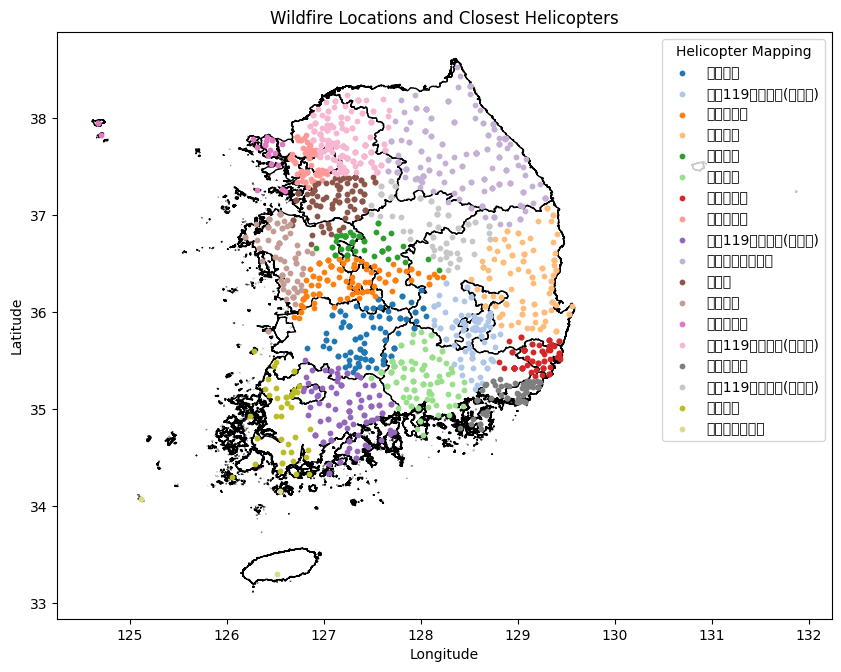

In [37]:
fig, ax = plt.subplots(figsize=(10, 8))

ctprvn_gdf.plot(ax=ax, color='white', edgecolor='black')

unique_helicopters = wildfire_df['소속'].unique()
colors = matplotlib.colormaps['tab20']
color_map = {helicopter: colors(i) for i, helicopter in enumerate(unique_helicopters)}

for helicopter, color in color_map.items():
    subset = wildfire_df[wildfire_df['소속'] == helicopter]
    ax.scatter(subset['경도'], subset['위도'], label=helicopter, color=color, s=10)

ax.legend(title='Helicopter Mapping')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_aspect('equal')
ax.set_title('Wildfire Locations and Closest Helicopters')

macOS에서 한글 그래프 출력이 불가능합니다. Windows 환경에서 재실행해 수정해주시면 감사하겠습니다.